# Imports

In [1]:
import random
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') 
print('device : ', device)
print('num gpu : ', torch.cuda.device_count())

device :  cuda
num gpu :  4


In [3]:
# torch.manual_seed(1234)
# np.random.seed(1234)
# random.seed(1234)

# Generate Data

In [4]:
class StepDataset(data.Dataset):
    
    def __init__(self, upper=5, lower=-3, length=100, error_range=0.1, center=1, ymax=1., x_var=None, y_var=None, model_mean=None):
        self.upper = upper
        self.lower = lower
        self.length = length
        self.error_range = error_range
        self.y_var = y_var
        if self.y_var != None:
            self.noise = np.array([np.random.normal(center,self.y_var) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        else:
            self.noise = np.array([2 * self.error_range * np. random.rand() - self.error_range for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.y_var = (2*self.error_range)**2/12
        
        if x_var != None:
            self.input = np.array([[(self.upper - self.lower) * np. random.rand() + self.lower, x_var] for i in range(self.length)]).astype(np.float32)
            self.output = np.array([[x.item()*ymax,self.y_var] for x in (self.input[:,0]>center)]).astype(np.float32)
            self.output[:,0] += self.noise.reshape(-1)
        else:    
            self.input = np.array([(self.upper - self.lower) * np. random.rand() + self.lower for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.output = (ymax * (self.input > center) + self.noise).astype(np.float32)
            if model_mean!=None:
                pred = model_mean(torch.tensor(self.input)).to("cpu")
                self.output = torch.abs(torch.tensor(self.output) - pred)


    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

In [5]:
dataset = StepDataset(ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x.shape

torch.Size([100, 1])

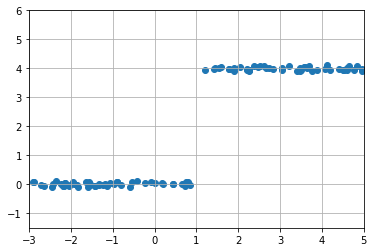

In [6]:
# dataset = StepDataset(ymax=4.)
dataset = StepDataset(5,-3,100,0.1,center=1,ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x = x[:,0]
y = y[:,0]


plt.scatter(x, y)
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.)
plt.grid()
plt.show()

# Basic Regression Model

## Modeling

In [7]:
class BasicRegressor(nn.Module):
    
    def __init__(self):
        super(BasicRegressor, self).__init__()
        self.layer1 = nn.Linear(1, 200)
        self.layer2 = nn.Linear(200, 200)
        self.last = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.01)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.last(out)
        
        return out

In [8]:
net = BasicRegressor().to(device)
print(net)
summary(net,(1,))

BasicRegressor(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (last): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]             400
           Dropout-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
           Dropout-4                  [-1, 200]               0
            Linear-5                    [-1, 1]             201
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
--------------------------------------------------

In [9]:
net = BasicRegressor()
net(torch.tensor([[0.]]))

tensor([[-0.1086]], grad_fn=<AddmmBackward>)

## Train

### Mean Model

In [39]:
def train_mean(model, dataloader, num_epochs, lr=2e-3):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [42]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_mean = BasicRegressor()
model_mean = train_mean(model_mean, dataloader,300,lr=5e-3)

-------------
Epoch 1/300
-------------
-------------
epoch 0 || Loss:0.2310 
timer:  0.0206 sec.
-------------
Epoch 2/300
-------------
-------------
epoch 1 || Loss:0.1663 
timer:  0.0164 sec.
-------------
Epoch 3/300
-------------
-------------
epoch 2 || Loss:0.0776 
timer:  0.0162 sec.
-------------
Epoch 4/300
-------------
-------------
epoch 3 || Loss:0.0865 
timer:  0.0173 sec.
-------------
Epoch 5/300
-------------
-------------
epoch 4 || Loss:0.0838 
timer:  0.0190 sec.
-------------
Epoch 6/300
-------------
-------------
epoch 5 || Loss:0.0612 
timer:  0.0165 sec.
-------------
Epoch 7/300
-------------
-------------
epoch 6 || Loss:0.0673 
timer:  0.0320 sec.
-------------
Epoch 8/300
-------------
-------------
epoch 7 || Loss:0.0690 
timer:  0.0318 sec.
-------------
Epoch 9/300
-------------
-------------
epoch 8 || Loss:0.0560 
timer:  0.0122 sec.
-------------
Epoch 10/300
-------------
-------------
epoch 9 || Loss:0.0540 
timer:  0.0162 sec.
-------------
Epoch

-------------
epoch 84 || Loss:0.0056 
timer:  0.0145 sec.
-------------
Epoch 86/300
-------------
-------------
epoch 85 || Loss:0.0078 
timer:  0.0155 sec.
-------------
Epoch 87/300
-------------
-------------
epoch 86 || Loss:0.0055 
timer:  0.0161 sec.
-------------
Epoch 88/300
-------------
-------------
epoch 87 || Loss:0.0055 
timer:  0.0191 sec.
-------------
Epoch 89/300
-------------
-------------
epoch 88 || Loss:0.0059 
timer:  0.0307 sec.
-------------
Epoch 90/300
-------------
-------------
epoch 89 || Loss:0.0065 
timer:  0.0237 sec.
-------------
Epoch 91/300
-------------
-------------
epoch 90 || Loss:0.0055 
timer:  0.0226 sec.
-------------
Epoch 92/300
-------------
-------------
epoch 91 || Loss:0.0062 
timer:  0.0123 sec.
-------------
Epoch 93/300
-------------
-------------
epoch 92 || Loss:0.0066 
timer:  0.0133 sec.
-------------
Epoch 94/300
-------------
-------------
epoch 93 || Loss:0.0074 
timer:  0.0106 sec.
-------------
Epoch 95/300
-------------


-------------
epoch 178 || Loss:0.0032 
timer:  0.0169 sec.
-------------
Epoch 180/300
-------------
-------------
epoch 179 || Loss:0.0029 
timer:  0.0290 sec.
-------------
Epoch 181/300
-------------
-------------
epoch 180 || Loss:0.0038 
timer:  0.0158 sec.
-------------
Epoch 182/300
-------------
-------------
epoch 181 || Loss:0.0030 
timer:  0.0273 sec.
-------------
Epoch 183/300
-------------
-------------
epoch 182 || Loss:0.0034 
timer:  0.0212 sec.
-------------
Epoch 184/300
-------------
-------------
epoch 183 || Loss:0.0029 
timer:  0.0140 sec.
-------------
Epoch 185/300
-------------
-------------
epoch 184 || Loss:0.0021 
timer:  0.0135 sec.
-------------
Epoch 186/300
-------------
-------------
epoch 185 || Loss:0.0022 
timer:  0.0140 sec.
-------------
Epoch 187/300
-------------
-------------
epoch 186 || Loss:0.0024 
timer:  0.0151 sec.
-------------
Epoch 188/300
-------------
-------------
epoch 187 || Loss:0.0019 
timer:  0.0150 sec.
-------------
Epoch 18

-------------
epoch 264 || Loss:0.0012 
timer:  0.0158 sec.
-------------
Epoch 266/300
-------------
-------------
epoch 265 || Loss:0.0015 
timer:  0.0326 sec.
-------------
Epoch 267/300
-------------
-------------
epoch 266 || Loss:0.0010 
timer:  0.0249 sec.
-------------
Epoch 268/300
-------------
-------------
epoch 267 || Loss:0.0009 
timer:  0.0283 sec.
-------------
Epoch 269/300
-------------
-------------
epoch 268 || Loss:0.0010 
timer:  0.0168 sec.
-------------
Epoch 270/300
-------------
-------------
epoch 269 || Loss:0.0007 
timer:  0.0178 sec.
-------------
Epoch 271/300
-------------
-------------
epoch 270 || Loss:0.0007 
timer:  0.0163 sec.
-------------
Epoch 272/300
-------------
-------------
epoch 271 || Loss:0.0009 
timer:  0.0194 sec.
-------------
Epoch 273/300
-------------
-------------
epoch 272 || Loss:0.0011 
timer:  0.0156 sec.
-------------
Epoch 274/300
-------------
-------------
epoch 273 || Loss:0.0012 
timer:  0.0256 sec.
-------------
Epoch 27

### Error Model

In [12]:
# dataset = StepDataset(ymax=4., model_mean=model_mean)
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
# x, y = next(iter(dataloader))
# y

In [13]:
class CustomLoss(nn.Module):
    
    def __init__(self, beta=0.1):
        super(CustomLoss, self).__init__()
        self.beta = beta
        
    def forward(self, x, y):
        dist = torch.sum(
            torch.pow((y - x).clamp(min=0.),2) + self.beta*torch.pow((y - x).clamp(max=0.),2)
            )
        loss = dist/(x.shape[0]*x.shape[1])
        return loss

In [40]:
def train_error(model, dataloader, num_epochs, lr=2e-3):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = CustomLoss(beta=0.1)
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [49]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.,model_mean=model_mean)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_error = BasicRegressor()

model_error = train_error(model_error, dataloader, 600, lr=5e-3)

-------------
Epoch 1/600
-------------
-------------
epoch 0 || Loss:0.0197 
timer:  0.0229 sec.
-------------
Epoch 2/600
-------------
-------------
epoch 1 || Loss:0.0149 
timer:  0.0205 sec.
-------------
Epoch 3/600
-------------
-------------
epoch 2 || Loss:0.0023 
timer:  0.0217 sec.
-------------
Epoch 4/600
-------------
-------------
epoch 3 || Loss:0.0041 
timer:  0.0194 sec.
-------------
Epoch 5/600
-------------
-------------
epoch 4 || Loss:0.0005 
timer:  0.0229 sec.
-------------
Epoch 6/600
-------------
-------------
epoch 5 || Loss:0.0015 
timer:  0.0250 sec.
-------------
Epoch 7/600
-------------
-------------
epoch 6 || Loss:0.0020 
timer:  0.0226 sec.
-------------
Epoch 8/600
-------------
-------------
epoch 7 || Loss:0.0013 
timer:  0.0223 sec.
-------------
Epoch 9/600
-------------
-------------
epoch 8 || Loss:0.0005 
timer:  0.0248 sec.
-------------
Epoch 10/600
-------------
-------------
epoch 9 || Loss:0.0005 
timer:  0.0231 sec.
-------------
Epoch

-------------
epoch 84 || Loss:0.0000 
timer:  0.0282 sec.
-------------
Epoch 86/600
-------------
-------------
epoch 85 || Loss:0.0000 
timer:  0.0201 sec.
-------------
Epoch 87/600
-------------
-------------
epoch 86 || Loss:0.0000 
timer:  0.0280 sec.
-------------
Epoch 88/600
-------------
-------------
epoch 87 || Loss:0.0000 
timer:  0.0221 sec.
-------------
Epoch 89/600
-------------
-------------
epoch 88 || Loss:0.0000 
timer:  0.0190 sec.
-------------
Epoch 90/600
-------------
-------------
epoch 89 || Loss:0.0000 
timer:  0.0223 sec.
-------------
Epoch 91/600
-------------
-------------
epoch 90 || Loss:0.0000 
timer:  0.0186 sec.
-------------
Epoch 92/600
-------------
-------------
epoch 91 || Loss:0.0000 
timer:  0.0256 sec.
-------------
Epoch 93/600
-------------
-------------
epoch 92 || Loss:0.0000 
timer:  0.0230 sec.
-------------
Epoch 94/600
-------------
-------------
epoch 93 || Loss:0.0000 
timer:  0.0363 sec.
-------------
Epoch 95/600
-------------


-------------
epoch 169 || Loss:0.0000 
timer:  0.0263 sec.
-------------
Epoch 171/600
-------------
-------------
epoch 170 || Loss:0.0000 
timer:  0.0230 sec.
-------------
Epoch 172/600
-------------
-------------
epoch 171 || Loss:0.0000 
timer:  0.0209 sec.
-------------
Epoch 173/600
-------------
-------------
epoch 172 || Loss:0.0000 
timer:  0.0213 sec.
-------------
Epoch 174/600
-------------
-------------
epoch 173 || Loss:0.0000 
timer:  0.0387 sec.
-------------
Epoch 175/600
-------------
-------------
epoch 174 || Loss:0.0000 
timer:  0.0183 sec.
-------------
Epoch 176/600
-------------
-------------
epoch 175 || Loss:0.0000 
timer:  0.0286 sec.
-------------
Epoch 177/600
-------------
-------------
epoch 176 || Loss:0.0000 
timer:  0.0203 sec.
-------------
Epoch 178/600
-------------
-------------
epoch 177 || Loss:0.0000 
timer:  0.0243 sec.
-------------
Epoch 179/600
-------------
-------------
epoch 178 || Loss:0.0000 
timer:  0.0241 sec.
-------------
Epoch 18

-------------
epoch 250 || Loss:0.0000 
timer:  0.0177 sec.
-------------
Epoch 252/600
-------------
-------------
epoch 251 || Loss:0.0000 
timer:  0.0166 sec.
-------------
Epoch 253/600
-------------
-------------
epoch 252 || Loss:0.0000 
timer:  0.0166 sec.
-------------
Epoch 254/600
-------------
-------------
epoch 253 || Loss:0.0000 
timer:  0.0159 sec.
-------------
Epoch 255/600
-------------
-------------
epoch 254 || Loss:0.0000 
timer:  0.0193 sec.
-------------
Epoch 256/600
-------------
-------------
epoch 255 || Loss:0.0000 
timer:  0.0214 sec.
-------------
Epoch 257/600
-------------
-------------
epoch 256 || Loss:0.0000 
timer:  0.0229 sec.
-------------
Epoch 258/600
-------------
-------------
epoch 257 || Loss:0.0000 
timer:  0.0232 sec.
-------------
Epoch 259/600
-------------
-------------
epoch 258 || Loss:0.0000 
timer:  0.0255 sec.
-------------
Epoch 260/600
-------------
-------------
epoch 259 || Loss:0.0000 
timer:  0.0187 sec.
-------------
Epoch 26

-------------
epoch 332 || Loss:0.0000 
timer:  0.0231 sec.
-------------
Epoch 334/600
-------------
-------------
epoch 333 || Loss:0.0000 
timer:  0.0366 sec.
-------------
Epoch 335/600
-------------
-------------
epoch 334 || Loss:0.0000 
timer:  0.0198 sec.
-------------
Epoch 336/600
-------------
-------------
epoch 335 || Loss:0.0000 
timer:  0.0197 sec.
-------------
Epoch 337/600
-------------
-------------
epoch 336 || Loss:0.0000 
timer:  0.0193 sec.
-------------
Epoch 338/600
-------------
-------------
epoch 337 || Loss:0.0000 
timer:  0.0217 sec.
-------------
Epoch 339/600
-------------
-------------
epoch 338 || Loss:0.0000 
timer:  0.0214 sec.
-------------
Epoch 340/600
-------------
-------------
epoch 339 || Loss:0.0000 
timer:  0.0287 sec.
-------------
Epoch 341/600
-------------
-------------
epoch 340 || Loss:0.0000 
timer:  0.0189 sec.
-------------
Epoch 342/600
-------------
-------------
epoch 341 || Loss:0.0000 
timer:  0.0214 sec.
-------------
Epoch 34

-------------
epoch 420 || Loss:0.0000 
timer:  0.0173 sec.
-------------
Epoch 422/600
-------------
-------------
epoch 421 || Loss:0.0000 
timer:  0.0215 sec.
-------------
Epoch 423/600
-------------
-------------
epoch 422 || Loss:0.0000 
timer:  0.0230 sec.
-------------
Epoch 424/600
-------------
-------------
epoch 423 || Loss:0.0000 
timer:  0.0172 sec.
-------------
Epoch 425/600
-------------
-------------
epoch 424 || Loss:0.0000 
timer:  0.0210 sec.
-------------
Epoch 426/600
-------------
-------------
epoch 425 || Loss:0.0000 
timer:  0.0187 sec.
-------------
Epoch 427/600
-------------
-------------
epoch 426 || Loss:0.0000 
timer:  0.0213 sec.
-------------
Epoch 428/600
-------------
-------------
epoch 427 || Loss:0.0000 
timer:  0.0176 sec.
-------------
Epoch 429/600
-------------
-------------
epoch 428 || Loss:0.0000 
timer:  0.0257 sec.
-------------
Epoch 430/600
-------------
-------------
epoch 429 || Loss:0.0000 
timer:  0.0225 sec.
-------------
Epoch 43

-------------
epoch 507 || Loss:0.0000 
timer:  0.0183 sec.
-------------
Epoch 509/600
-------------
-------------
epoch 508 || Loss:0.0000 
timer:  0.0180 sec.
-------------
Epoch 510/600
-------------
-------------
epoch 509 || Loss:0.0000 
timer:  0.0311 sec.
-------------
Epoch 511/600
-------------
-------------
epoch 510 || Loss:0.0000 
timer:  0.0199 sec.
-------------
Epoch 512/600
-------------
-------------
epoch 511 || Loss:0.0000 
timer:  0.0176 sec.
-------------
Epoch 513/600
-------------
-------------
epoch 512 || Loss:0.0000 
timer:  0.0190 sec.
-------------
Epoch 514/600
-------------
-------------
epoch 513 || Loss:0.0000 
timer:  0.0183 sec.
-------------
Epoch 515/600
-------------
-------------
epoch 514 || Loss:0.0000 
timer:  0.0169 sec.
-------------
Epoch 516/600
-------------
-------------
epoch 515 || Loss:0.0000 
timer:  0.0186 sec.
-------------
Epoch 517/600
-------------
-------------
epoch 516 || Loss:0.0000 
timer:  0.0188 sec.
-------------
Epoch 51

-------------
epoch 588 || Loss:0.0000 
timer:  0.0231 sec.
-------------
Epoch 590/600
-------------
-------------
epoch 589 || Loss:0.0000 
timer:  0.0255 sec.
-------------
Epoch 591/600
-------------
-------------
epoch 590 || Loss:0.0000 
timer:  0.0300 sec.
-------------
Epoch 592/600
-------------
-------------
epoch 591 || Loss:0.0000 
timer:  0.0272 sec.
-------------
Epoch 593/600
-------------
-------------
epoch 592 || Loss:0.0000 
timer:  0.0404 sec.
-------------
Epoch 594/600
-------------
-------------
epoch 593 || Loss:0.0000 
timer:  0.0414 sec.
-------------
Epoch 595/600
-------------
-------------
epoch 594 || Loss:0.0000 
timer:  0.0261 sec.
-------------
Epoch 596/600
-------------
-------------
epoch 595 || Loss:0.0000 
timer:  0.0269 sec.
-------------
Epoch 597/600
-------------
-------------
epoch 596 || Loss:0.0000 
timer:  0.0264 sec.
-------------
Epoch 598/600
-------------
-------------
epoch 597 || Loss:0.0000 
timer:  0.0362 sec.
-------------
Epoch 59

## Validation

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


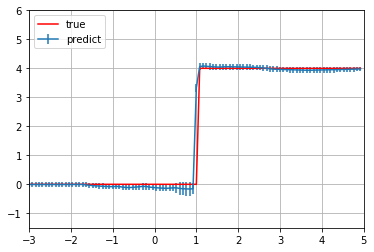

In [50]:
length = 100
start = -3
end = 5
waith = end - start
val_x = torch.tensor([[i] for i in np.arange(start,end,waith/length)])
val_y = (val_x>1)*4
pred_y = model_mean(val_x).detach().cpu()
pred_std = model_error(val_x).detach().cpu()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.plot(val_x, pred_y,  label="predict")
ax.errorbar(val_x, pred_y, pred_std, label="predict")
ax.plot(val_x, val_y, label="true",c="red")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6)
fig.show()

# Stochastic Reression

## Modeling

### Modified ReLU

In [17]:
def ReLUGauss(mu_in, var_in, epsilon=1.0e-6, cut_sd=4.0):
    mu_out = torch.zeros(mu_in.shape[0], mu_in.shape[1])
    var_out = torch.zeros(var_in.shape[0], var_in.shape[1])
    mu = mu_in
    var = var_in
    sigma = torch.sqrt(var+1e-16)

    if (var < 0).any().item(): raise Exception(f"ERROR in ReLUGauss: 'var_in' should be all positive value, but it has negative value.")
    idx_SmallSigma = (sigma < epsilon)
    if cut_sd != None:
        idx_LargeMu = (mu > cut_sd*sigma)
        idx_SmallMU = (mu < -cut_sd*sigma)

    sqrt2 = math.sqrt(2.0)
    sqrt2pi = math.sqrt(2.0*math.pi)    
    z = mu / (sqrt2*sigma+1e-16)
    E = torch.erf(z)
    X = torch.exp(-z*z)
    mu_out = sigma/sqrt2pi*X + mu/2.0*(1.0+E)
    var_out = (1.0+E)/4.0*(mu*mu*(1.0-E)+2.0*var) - sigma*X/sqrt2pi*(sigma*X/sqrt2pi+mu*E)
    
    idx_SmallVarOut = (var_out<0.0)*(var_out>-epsilon)
    isError = ((var_out<0.0)*(var_out<=-epsilon)).any().item()
    if isError:
        msg= f'ERROR in ReLUGauss: (mu: {mu}\n, sigma: {sigma}\n, mu_out: {mu_out}\n, var_out: {var_out}\n)'
        print(msg)
        raise Exception(msg)


    mu_out = mu_out*~idx_SmallSigma + idx_SmallSigma*torch.relu(mu)
    var_out *= ~idx_SmallSigma
    if cut_sd != None:
        mu_out = mu_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*mu
        var_out = var_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*var
        mu_out = mu_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallVarOut*~((idx_LargeMu|idx_SmallSigma)|idx_SmallMU))
    else:
        var_out = var_out*~(idx_SmallVarOut*~idx_SmallSigma)
            
    var_out = torch.diag_embed(var_out)
    
    return mu_out, var_out

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


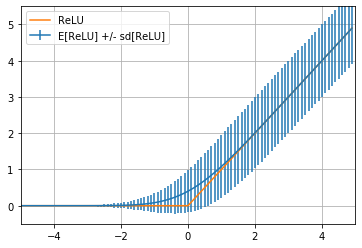

In [18]:
length = 100
start = -5
end = 5
waith = end - start
x = torch.arange(start, end, waith/length).view(-1, 1)
in_var = torch.ones(length, 1)
y, out_var = ReLUGauss(x, in_var)
out_var = out_var.reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, torch.sqrt(out_var), label="E[ReLU] +/- sd[ReLU]")
ax.plot(x, torch.relu(x), label="ReLU")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(start, end)
plt.ylim(-0.5, end+0.5)
fig.show()

### Custom DropOut

In [19]:
class CustomDropout(nn.Module):
    
    __constants__ = ['p', 'inplace']

    def __init__(self, p=0.5, inplace=False):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.inplace = inplace
        self.flag = torch.zeros(1,1)
    
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]    
        self.flag = F.dropout(torch.ones(mu_in.shape[0], mu_in.shape[1]), self.p, self.training, self.inplace)
        self.flag = self.flag.to(device)
        try:           
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        except:     
            self.flag = self.flag.to("cpu")
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        
        return mu_out, var_out
    
    def extra_repr(self):
        return 'p={}, inplace={}'.format(self.p, self.inplace)
    
    def to(self, *args, **kwargs):
        self.b = self.flag.to(*args, **kwargs) 
        return self

### Modeling

In [20]:
def ModifyInput(input):
    if input.dim() == 2:
        mu = input[:, 0].unsqueeze(-1)
        var = input[:, 1].unsqueeze(-1).unsqueeze(-1)
    else:
        raise Exception("Input shape should be (BATCH x 2).")
    return mu, var

def ModifyOutput(input):
    mu = input[0]
    var = input[1]
    out = torch.cat([mu, var], dim=1)
        
    return out


class StochasticLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(StochasticLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out = mu_in @ self.weight.T + self.bias
        var_out = torch.diagonal(self.weight @ var_in @ self.weight.T, dim1=-2, dim2=-1)
                
        return mu_out, var_out
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias
        )
    
    
class StochasticReLU(nn.Module):
    def __init__(self, inplace=False):
        super(StochasticReLU, self).__init__()
        self.inplace = inplace
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out, var_out = ReLUGauss(mu_in, var_in)
        return mu_out, var_out
        
    def extra_repr(self):
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [21]:
class StochasticRegressor(nn.Module):
    
    def __init__(self):
        super(StochasticRegressor, self).__init__()
        self.layer1 = StochasticLinear(1, 200)
        self.layer2 = StochasticLinear(200, 200)
        self.last = StochasticLinear(200, 1)
        self.dropout = CustomDropout(p=0.01)
        
    def forward(self, x):
        out = ModifyInput(x)
        out = self.layer1(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.last(out)
        out = ModifyOutput(out)
        
        return out

## Get Weigts

In [22]:
def LoadMeanWeight(model_mean, model_stochastic):
    length = len(model_mean.state_dict().keys())
    keys_mean = iter(model_mean.state_dict().keys())
    keys_stochastic = iter(model_stochastic.state_dict().keys())
    for i in range(length):
        model_stochastic.state_dict()[next(keys_stochastic)][:] = model_mean.state_dict()[next(keys_mean)]
    
    model_stochastic.eval()
    return model_stochastic

In [23]:
model_stochastic = StochasticRegressor()
model_stochastic = LoadMeanWeight(model_mean, model_stochastic)

## Prediction

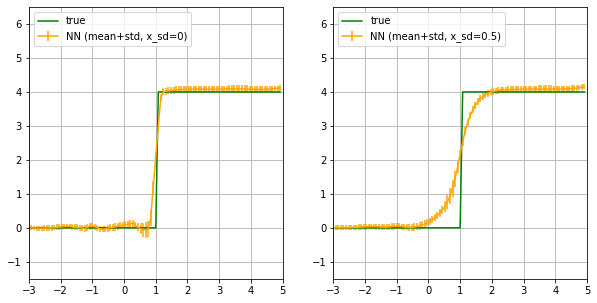

In [51]:
length = 100
start = -3
end = 5
waith = end - start
in_var1 = 0.
in_var2 = 0.25
val_x1 = torch.tensor([[i, in_var1] for i in np.arange(start,end,waith/length)])
val_x2 = torch.tensor([[i, in_var2] for i in np.arange(start,end,waith/length)])
val_y = (val_x1[:,0]>1)*4

pred_y1 = model_stochastic(val_x1).detach().cpu()
mu1 = pred_y1[:,0]
std1 = torch.sqrt(pred_y1[:,1] + torch.pow(model_error(val_x[:,0].view(-1,1)).detach().cpu(),2).view(-1))

pred_y2 = model_stochastic(val_x2).detach().cpu()
mu2 = pred_y2[:,0]
std2 = torch.sqrt(pred_y1[:,1] + torch.pow(model_error(val_x[:,0].view(-1,1)).detach().cpu(),2).view(-1))


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(val_x[:,0], mu1, std1, label="NN (mean+std, x_sd=0)",c="orange")
ax1.plot(val_x[:,0], val_y, label="true",c="g")
ax1.grid()
ax1.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.5)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(val_x[:,0], mu2, std2, label="NN (mean+std, x_sd=0.5)",c="orange")
ax2.plot(val_x[:,0], val_y, label="true",c="g")
ax2.grid()
ax2.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.5)

fig.show()

# Regressrion Linear Function with changing noize

In [25]:
class LinearDataset(data.Dataset):
    
    def __init__(self, upper=5, lower=-5, length=100, error_range1=1, error_range2=0.25, model_mean=None):
        self.length = length
        noise1 = np.array([np.random.uniform(-error_range1,error_range1) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        noise2 = np.array([np.random.uniform(-error_range2,error_range2) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
         
        self.input = np.array([np.random.uniform(lower,upper) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        self.output = (0.5 * self.input).astype(np.float32)
        self.output[np.abs(self.output)<1] += np.array([np.random.uniform(-error_range1,error_range1) for i in range(len(self.output[np.abs(self.output)<1]))]).astype(np.float32)
        self.output[np.abs(self.output)>=1] += np.array([np.random.uniform(-error_range2,error_range2) for i in range(len(self.output[np.abs(self.output)>=1]))]).astype(np.float32)
        if model_mean!=None:
            pred = model_mean(torch.tensor(self.input)).to("cpu")
            self.output = torch.abs(torch.tensor(self.output) - pred)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

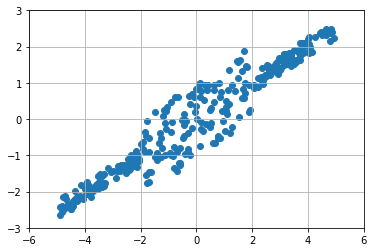

In [26]:
dataset = LinearDataset(length=300)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
x, y = next(iter(dataloader))

plt.scatter(x, y)
plt.xlim(-6, 6)
plt.ylim(-3, 3)
plt.grid()
plt.show()

In [27]:
dataset = LinearDataset(length=300)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_mean_l = BasicRegressor()
model_mean_l = train_mean(model_mean_l, dataloader,30)

-------------
Epoch 1/30
-------------
-------------
epoch 0 || Loss:0.0988 
timer:  0.0380 sec.
-------------
Epoch 2/30
-------------
-------------
epoch 1 || Loss:0.0294 
timer:  0.0353 sec.
-------------
Epoch 3/30
-------------
-------------
epoch 2 || Loss:0.0256 
timer:  0.0381 sec.
-------------
Epoch 4/30
-------------
-------------
epoch 3 || Loss:0.0180 
timer:  0.0488 sec.
-------------
Epoch 5/30
-------------
-------------
epoch 4 || Loss:0.0162 
timer:  0.0291 sec.
-------------
Epoch 6/30
-------------
-------------
epoch 5 || Loss:0.0163 
timer:  0.0474 sec.
-------------
Epoch 7/30
-------------
-------------
epoch 6 || Loss:0.0151 
timer:  0.0442 sec.
-------------
Epoch 8/30
-------------
-------------
epoch 7 || Loss:0.0150 
timer:  0.0660 sec.
-------------
Epoch 9/30
-------------
-------------
epoch 8 || Loss:0.0143 
timer:  0.0338 sec.
-------------
Epoch 10/30
-------------
-------------
epoch 9 || Loss:0.0150 
timer:  0.0438 sec.
-------------
Epoch 11/30
---

In [28]:
dataset = LinearDataset(length=300, model_mean=model_mean_l)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

model_error_l = BasicRegressor()
model_error_l = train_error(model_error_l, dataloader,600)

-------------
Epoch 1/600
-------------
-------------
epoch 0 || Loss:0.0184 
timer:  0.0864 sec.
-------------
Epoch 2/600
-------------
-------------
epoch 1 || Loss:0.0140 
timer:  0.0607 sec.
-------------
Epoch 3/600
-------------
-------------
epoch 2 || Loss:0.0051 
timer:  0.0704 sec.
-------------
Epoch 4/600
-------------
-------------
epoch 3 || Loss:0.0040 
timer:  0.0586 sec.
-------------
Epoch 5/600
-------------
-------------
epoch 4 || Loss:0.0028 
timer:  0.0480 sec.
-------------
Epoch 6/600
-------------
-------------
epoch 5 || Loss:0.0028 
timer:  0.0496 sec.
-------------
Epoch 7/600
-------------
-------------
epoch 6 || Loss:0.0024 
timer:  0.0524 sec.
-------------
Epoch 8/600
-------------
-------------
epoch 7 || Loss:0.0021 
timer:  0.0592 sec.
-------------
Epoch 9/600
-------------
-------------
epoch 8 || Loss:0.0020 
timer:  0.0548 sec.
-------------
Epoch 10/600
-------------
-------------
epoch 9 || Loss:0.0020 
timer:  0.0597 sec.
-------------
Epoch

-------------
epoch 85 || Loss:0.0014 
timer:  0.0658 sec.
-------------
Epoch 87/600
-------------
-------------
epoch 86 || Loss:0.0015 
timer:  0.0617 sec.
-------------
Epoch 88/600
-------------
-------------
epoch 87 || Loss:0.0015 
timer:  0.0643 sec.
-------------
Epoch 89/600
-------------
-------------
epoch 88 || Loss:0.0014 
timer:  0.0551 sec.
-------------
Epoch 90/600
-------------
-------------
epoch 89 || Loss:0.0013 
timer:  0.0657 sec.
-------------
Epoch 91/600
-------------
-------------
epoch 90 || Loss:0.0015 
timer:  0.0593 sec.
-------------
Epoch 92/600
-------------
-------------
epoch 91 || Loss:0.0015 
timer:  0.0582 sec.
-------------
Epoch 93/600
-------------
-------------
epoch 92 || Loss:0.0015 
timer:  0.0501 sec.
-------------
Epoch 94/600
-------------
-------------
epoch 93 || Loss:0.0015 
timer:  0.0735 sec.
-------------
Epoch 95/600
-------------
-------------
epoch 94 || Loss:0.0014 
timer:  0.0608 sec.
-------------
Epoch 96/600
-------------


-------------
epoch 167 || Loss:0.0013 
timer:  0.0576 sec.
-------------
Epoch 169/600
-------------
-------------
epoch 168 || Loss:0.0014 
timer:  0.1001 sec.
-------------
Epoch 170/600
-------------
-------------
epoch 169 || Loss:0.0013 
timer:  0.0526 sec.
-------------
Epoch 171/600
-------------
-------------
epoch 170 || Loss:0.0012 
timer:  0.0708 sec.
-------------
Epoch 172/600
-------------
-------------
epoch 171 || Loss:0.0013 
timer:  0.0525 sec.
-------------
Epoch 173/600
-------------
-------------
epoch 172 || Loss:0.0013 
timer:  0.0541 sec.
-------------
Epoch 174/600
-------------
-------------
epoch 173 || Loss:0.0012 
timer:  0.0620 sec.
-------------
Epoch 175/600
-------------
-------------
epoch 174 || Loss:0.0013 
timer:  0.0607 sec.
-------------
Epoch 176/600
-------------
-------------
epoch 175 || Loss:0.0012 
timer:  0.0500 sec.
-------------
Epoch 177/600
-------------
-------------
epoch 176 || Loss:0.0014 
timer:  0.0705 sec.
-------------
Epoch 17

-------------
epoch 249 || Loss:0.0012 
timer:  0.0466 sec.
-------------
Epoch 251/600
-------------
-------------
epoch 250 || Loss:0.0014 
timer:  0.0760 sec.
-------------
Epoch 252/600
-------------
-------------
epoch 251 || Loss:0.0014 
timer:  0.0604 sec.
-------------
Epoch 253/600
-------------
-------------
epoch 252 || Loss:0.0013 
timer:  0.0616 sec.
-------------
Epoch 254/600
-------------
-------------
epoch 253 || Loss:0.0014 
timer:  0.0749 sec.
-------------
Epoch 255/600
-------------
-------------
epoch 254 || Loss:0.0014 
timer:  0.0568 sec.
-------------
Epoch 256/600
-------------
-------------
epoch 255 || Loss:0.0013 
timer:  0.0692 sec.
-------------
Epoch 257/600
-------------
-------------
epoch 256 || Loss:0.0012 
timer:  0.0863 sec.
-------------
Epoch 258/600
-------------
-------------
epoch 257 || Loss:0.0013 
timer:  0.0614 sec.
-------------
Epoch 259/600
-------------
-------------
epoch 258 || Loss:0.0012 
timer:  0.0699 sec.
-------------
Epoch 26

-------------
epoch 333 || Loss:0.0011 
timer:  0.0600 sec.
-------------
Epoch 335/600
-------------
-------------
epoch 334 || Loss:0.0011 
timer:  0.0577 sec.
-------------
Epoch 336/600
-------------
-------------
epoch 335 || Loss:0.0012 
timer:  0.0626 sec.
-------------
Epoch 337/600
-------------
-------------
epoch 336 || Loss:0.0012 
timer:  0.0712 sec.
-------------
Epoch 338/600
-------------
-------------
epoch 337 || Loss:0.0013 
timer:  0.0653 sec.
-------------
Epoch 339/600
-------------
-------------
epoch 338 || Loss:0.0012 
timer:  0.0578 sec.
-------------
Epoch 340/600
-------------
-------------
epoch 339 || Loss:0.0013 
timer:  0.0690 sec.
-------------
Epoch 341/600
-------------
-------------
epoch 340 || Loss:0.0013 
timer:  0.0605 sec.
-------------
Epoch 342/600
-------------
-------------
epoch 341 || Loss:0.0012 
timer:  0.0551 sec.
-------------
Epoch 343/600
-------------
-------------
epoch 342 || Loss:0.0012 
timer:  0.0716 sec.
-------------
Epoch 34

-------------
epoch 417 || Loss:0.0011 
timer:  0.0547 sec.
-------------
Epoch 419/600
-------------
-------------
epoch 418 || Loss:0.0011 
timer:  0.0767 sec.
-------------
Epoch 420/600
-------------
-------------
epoch 419 || Loss:0.0013 
timer:  0.0608 sec.
-------------
Epoch 421/600
-------------
-------------
epoch 420 || Loss:0.0011 
timer:  0.0491 sec.
-------------
Epoch 422/600
-------------
-------------
epoch 421 || Loss:0.0012 
timer:  0.0553 sec.
-------------
Epoch 423/600
-------------
-------------
epoch 422 || Loss:0.0011 
timer:  0.0498 sec.
-------------
Epoch 424/600
-------------
-------------
epoch 423 || Loss:0.0011 
timer:  0.0428 sec.
-------------
Epoch 425/600
-------------
-------------
epoch 424 || Loss:0.0012 
timer:  0.0384 sec.
-------------
Epoch 426/600
-------------
-------------
epoch 425 || Loss:0.0012 
timer:  0.0516 sec.
-------------
Epoch 427/600
-------------
-------------
epoch 426 || Loss:0.0013 
timer:  0.0679 sec.
-------------
Epoch 42

-------------
epoch 501 || Loss:0.0012 
timer:  0.0531 sec.
-------------
Epoch 503/600
-------------
-------------
epoch 502 || Loss:0.0012 
timer:  0.0469 sec.
-------------
Epoch 504/600
-------------
-------------
epoch 503 || Loss:0.0011 
timer:  0.0419 sec.
-------------
Epoch 505/600
-------------
-------------
epoch 504 || Loss:0.0012 
timer:  0.0461 sec.
-------------
Epoch 506/600
-------------
-------------
epoch 505 || Loss:0.0012 
timer:  0.0600 sec.
-------------
Epoch 507/600
-------------
-------------
epoch 506 || Loss:0.0012 
timer:  0.0555 sec.
-------------
Epoch 508/600
-------------
-------------
epoch 507 || Loss:0.0012 
timer:  0.0502 sec.
-------------
Epoch 509/600
-------------
-------------
epoch 508 || Loss:0.0011 
timer:  0.0546 sec.
-------------
Epoch 510/600
-------------
-------------
epoch 509 || Loss:0.0011 
timer:  0.0566 sec.
-------------
Epoch 511/600
-------------
-------------
epoch 510 || Loss:0.0011 
timer:  0.0672 sec.
-------------
Epoch 51

-------------
epoch 583 || Loss:0.0011 
timer:  0.0484 sec.
-------------
Epoch 585/600
-------------
-------------
epoch 584 || Loss:0.0011 
timer:  0.0593 sec.
-------------
Epoch 586/600
-------------
-------------
epoch 585 || Loss:0.0011 
timer:  0.0677 sec.
-------------
Epoch 587/600
-------------
-------------
epoch 586 || Loss:0.0011 
timer:  0.0597 sec.
-------------
Epoch 588/600
-------------
-------------
epoch 587 || Loss:0.0011 
timer:  0.0522 sec.
-------------
Epoch 589/600
-------------
-------------
epoch 588 || Loss:0.0012 
timer:  0.0577 sec.
-------------
Epoch 590/600
-------------
-------------
epoch 589 || Loss:0.0011 
timer:  0.0601 sec.
-------------
Epoch 591/600
-------------
-------------
epoch 590 || Loss:0.0012 
timer:  0.0582 sec.
-------------
Epoch 592/600
-------------
-------------
epoch 591 || Loss:0.0011 
timer:  0.0620 sec.
-------------
Epoch 593/600
-------------
-------------
epoch 592 || Loss:0.0011 
timer:  0.0444 sec.
-------------
Epoch 59

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


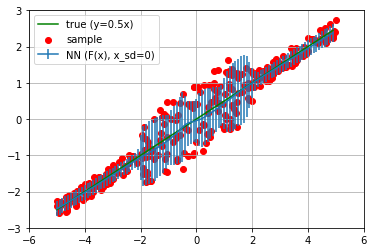

In [29]:
length = 100
start = -5
end = 5
waith = end - start
val_x = torch.tensor([[i] for i in np.arange(start,end,waith/length)])
val_y = 0.5*val_x
pred_y = model_mean_l(val_x).detach().cpu()
pred_std = model_error_l(val_x).detach().cpu()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(val_x, pred_y, pred_std, label="NN (F(x), x_sd=0)")
ax.plot(val_x, val_y, label="true (y=0.5x)",c="g")

dataset = LinearDataset(length=300)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
x, y = next(iter(dataloader))
ax.scatter(x, y,c="r",label="sample")

ax.grid()
ax.legend(loc='upper left')
plt.xlim(-6, 6)
plt.ylim(-3, 3)
fig.show()

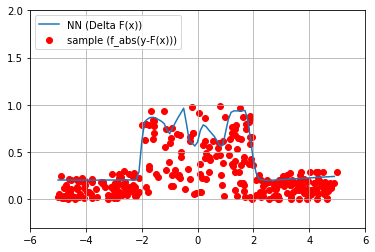

In [30]:
dataset = LinearDataset(length=300, model_mean=model_mean_l)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=300,shuffle=True)
dataloader = iter(dataloader)
x,y = next(dataloader)
y = y.detach().cpu()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y,c="r",label="sample (f_abs(y-F(x)))")
ax.plot(val_x,pred_std,label="NN (Delta F(x))")

ax.grid()
ax.legend(loc='upper left')
plt.xlim(-6, 6)
plt.ylim(-0.3, 2)
fig.show()